# Problem 1 

## Problem Description
As a lecture activity, you performed support vector classification on a linearly separable dataset by solving the quadratic programming optimization problem to create a large margin classifier.

Now, you will use a similar approach to create a soft margin classifier on a dataset that is not cleanly separable.

Fill out the notebook as instructed, making the requested plots and printing necessary values. 

*You are welcome to use any of the code provided in the lecture activities.*

#### Summary of deliverables:
Functions (described later):
- `soft_margin_svm(X,y,C)`

Results:
- Print the values of w1, w2, and b for the C=0.05 case

Plots:
- Plot the data with the optimized margin and decision boundary for the case C=0.05
- Make 4 such plots for the requested C values

Discussion:
- Respond to the prompt asked at the end of the notebook

#### Imports and Utility Functions:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def plot_boundary(x, y, w1, w2, b, e=0.1):
    x1min, x1max = min(x[:,0]), max(x[:,0])
    x2min, x2max = min(x[:,1]), max(x[:,1])
    
    xb = np.linspace(x1min,x1max)
    y_0 = 1/w2*(-b-w1*xb)
    y_1 = 1/w2*(1-b-w1*xb)
    y_m1 = 1/w2*(-1-b-w1*xb)
    
    cmap = ListedColormap(["purple","orange"])

    plt.scatter(x[:,0],x[:,1],c=y,cmap=cmap)
    plt.plot(xb,y_0,'-',c='blue')
    plt.plot(xb,y_1,'--',c='green')
    plt.plot(xb,y_m1,'--',c='green')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.axis((x1min-e,x1max+e,x2min-e,x2max+e))

## Load data
Data is loaded as follows:  
- X: input features, Nx2 array  
- y: output class, length N array

In [4]:
data = np.load("data/w4-hw1-data.npy")
X = data[:, 0:2]
y = data[:, 2]

## Soft Margin SVM Optimization Problem

For soft-margin SVM, we introduce N slack variables $\xi_i$ (one for each point), and reformulate the optimization problem as:

$$
\min_{\boldsymbol{w}, b}\qquad \frac{1}{2}||\boldsymbol{w}||^2 + C \sum_i \xi_i
$$

$$
\text{subject to:}\quad y_i(\boldsymbol{w}^T \boldsymbol{x}_i+b)\geq 1 - \xi_i;\quad \xi_i \geq 0
$$

To put this into a form compatible with `cvxopt`, we will need to assemble large matrices as described in the next section.


## Soft Margin SVM function

Define a function `soft_margin_svm(X, y, C)` with inputs:
- `X`: (Nx2) array of input features
- `y`: Length N array of output classes, -1 or 1
- `C`: Regularization parameter

In this function, do the following steps:

1. Create the P, q, G, and h arrays for this problem (each comprised of multiple sub-matrices you need to combine into one)
- `P`: (3+N) x (3+N)
  - Upper left: Identity matrix, but with 0 instead of 1 for the bias (third) row/column
  - Upper right (3xN): Zeros
  - Lower left (Nx3): Zeros
  - Lower right: (NxN): Zeros
- `q`: (3+N) x (1)
  - Top (3x1): Vector of zeros
  - Bottom (Nx1): Vector filled with 'C'
- `G`: (N+N) x (N+3): 
  - Upper left (Nx3): Negative y multiplied element-wise by [`x1`, `x2`, `1`]
  - Upper right (NxN): Negative identity matrix
  - Lower left (Nx3): Zeros
  - Lower right (NxN): Negative identity matrix
- `h`: (N+N) x (1)
  - Top: Vector of -1
  - Bottom: Vector of zeros

You can use `np.block()` to combine multiple submatrices into one.

2. Convert each of these into cvxopt matrices (Provided)

3. Solve the problem using `cvxopt.solvers.qp` (Provided)

4. Extract the `w1`, `w2`, and `b` values from the solution, and return them (Provided)

In [5]:
def soft_margin_svm(X, y, C):
    N = np.shape(X)[0]
    P = np.zeros((3+N, 3+N))
    P[0,0] = 1.0
    P[1,1] = 1.0
    
    q = np.vstack([np.zeros((3,1)), C * np.ones((N,1))])
    
    G_top_left = -(y[:, None] * np.hstack([X, np.ones((N, 1))]))  # (N,3)
    G_top_right = -np.eye(N)
    G_bottom_left = np.zeros((N, 3))
    G_bottom_right = -np.eye(N)
    G = np.vstack([
        np.hstack([G_top_left, G_top_right]),
        np.hstack([G_bottom_left, G_bottom_right]),
    ])

    h = np.hstack([-np.ones(N), np.zeros(N)])
    
    z = solvers.qp(matrix(P),matrix(q),matrix(G),matrix(h))
    w1 = z['x'][0]
    w2 = z['x'][1]
    b  = z['x'][2]

    return w1, w2, b

## Demo: C = 0.05
Run the cell below to create the plot for the N = 0.05 case


Solution
--------
w1:  -0.2685
w2:   0.1857
 b:   1.1785


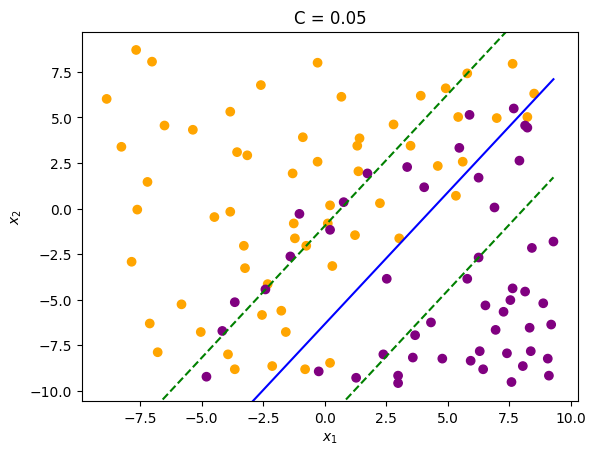

In [6]:
C = 0.05
w1, w2, b = soft_margin_svm(X, y, C)
print(f"\nSolution\n--------\nw1: {w1:8.4f}\nw2: {w2:8.4f}\n b: {b:8.4f}")

plt.figure()
plot_boundary(X,y,w1,w2,b,e=1)
plt.title(f"C = {C}")
plt.show()

## Varying C
Now loop over the C values [1e-5, 1e-3, 1e-2, 1] and generate soft margin decision boundary plots like the one above for each case.


Solution
--------
w1:  -0.0025
w2:   0.0020
 b:   0.9807


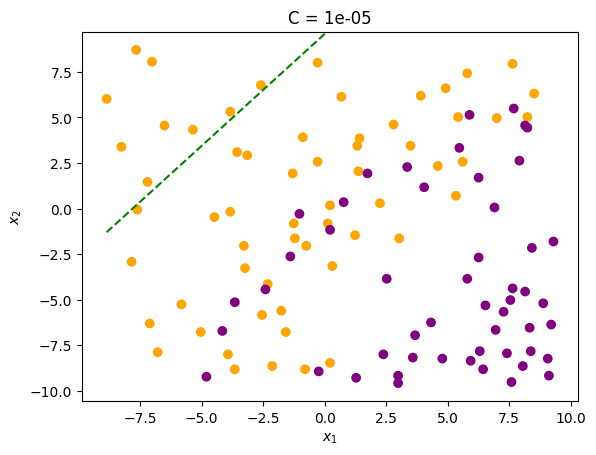


Solution
--------
w1:  -0.1323
w2:   0.1006
 b:   0.6562


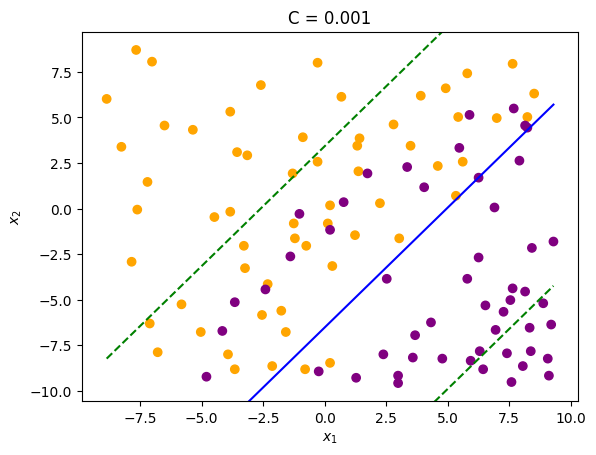


Solution
--------
w1:  -0.2231
w2:   0.1661
 b:   1.0017


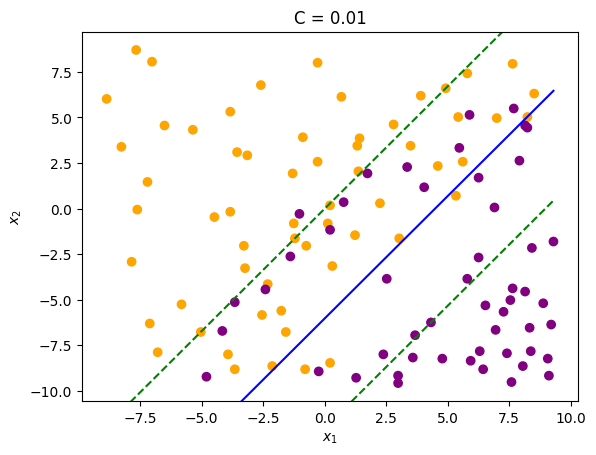


Solution
--------
w1:  -0.2899
w2:   0.1873
 b:   1.1899


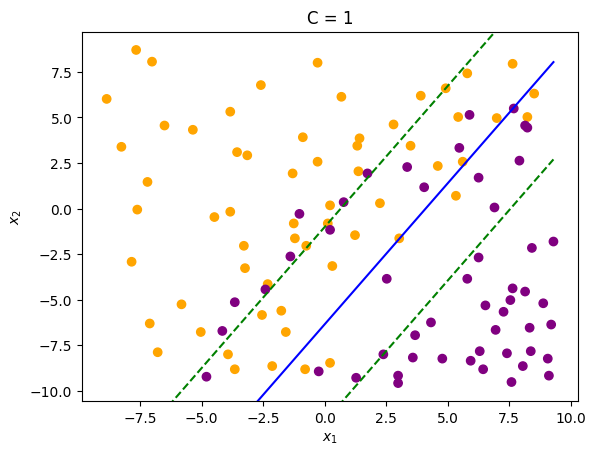

In [8]:
C_values = [1e-5, 1e-3, 1e-2, 1]

for C in C_values:
    w1, w2, b = soft_margin_svm(X, y, C)
    
    print(f"\nSolution\n--------\nw1: {w1:8.4f}\nw2: {w2:8.4f}\n b: {b:8.4f}")

    plt.figure()
    plot_boundary(X, y, w1, w2, b, e=1)
    plt.title(f"C = {C}")
    plt.show()

## Discussion

Please write a sentence or two discussing what happens to the decision boundary and margin as you vary C, and try to provide some rationale for why.

For higher C values, the SVM penalizes more heavily, so the optimizer tries harder to correctly classify every training point. As the C increases the margin keeps getting narrower, the higher C increases the w to correctly classify more points. Very large C can overfit the model though